In [1]:
from networks import AttnVGG
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# from transforms import *

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='../data_mnist_train',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = datasets.FashionMNIST(
    root='../data_mnist_test',
    train=False,
    download=True,
    transform=transform_train
)

In [3]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=10
)

In [4]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
num_classes = len(class_names)

In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

In [6]:
def show_images_with_labels(images, labels):
    fig = plt.figure(figsize=(10, 4))
    for idx in range(5):
        print(images[idx].shape)
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx][0].squeeze(), cmap='gray')
        ax.set_title(class_names[labels[idx].item()])
    plt.show()

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


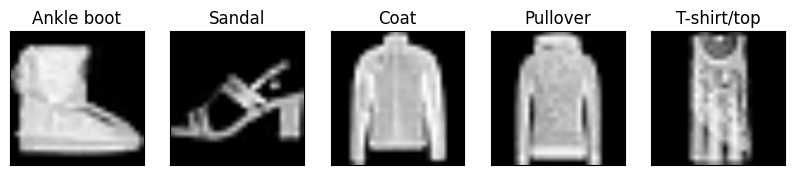

In [7]:
show_images_with_labels(images, labels)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttnVGG(num_classes=num_classes, attention=True, normalize_attn=True).to(device)
# print(model)

lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=lr
)

total_epochs = 3
best_acc = 0.0
loss_history = [[] for x in range(total_epochs)]
loss_history_test = [[] for x in range(total_epochs)]
history = []
# history = [{} for x in range(total_epochs)]

for epoch in range(total_epochs):
    model.train()
    epoch_start = time.time()
    running_loss = 0.0
    val_loss = 0.0
    total_train = 0
    correct_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs}", leave=False)

    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        # 32, 3, 224, 224
        outputs, __, __ = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_train += images.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history[epoch].append(loss.item())
        train_loop.set_postfix(loss=loss.item())

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, __, __ = model(images)

            test_loss = criterion(outputs, labels)
            loss_history_test[epoch].append(test_loss.item())
            val_loss += test_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    train_acc = 100 * correct_train / total_train

    epoch_time = time.time() - epoch_start
    history.append(
        {
            'loss': running_loss / len(train_loader),
            'val_loss': val_loss / len(train_loader),
            'train_acc': train_acc,
            'val_acc': val_acc,
            'epoch_time': epoch_time,
        }
    )
    print(
        f"Epoch [{epoch + 1}/{total_epochs}] | "
        f"Loss: {running_loss / len(train_loader):.4f} | "
        f"Val Acc: {val_acc:.2f}% | "
        f"Time: {epoch_time:.2f}s"
    )

/home/washindeiru/.venv/data_torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/washindeiru/.venv/data_torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/3] | Loss: 0.3935 | Val Acc: 90.27% | Time: 758.75s


Epoch [2/3] | Loss: 0.2353 | Val Acc: 92.20% | Time: 670.88s


Epoch [3/3] | Loss: 0.2016 | Val Acc: 92.17% | Time: 688.73s


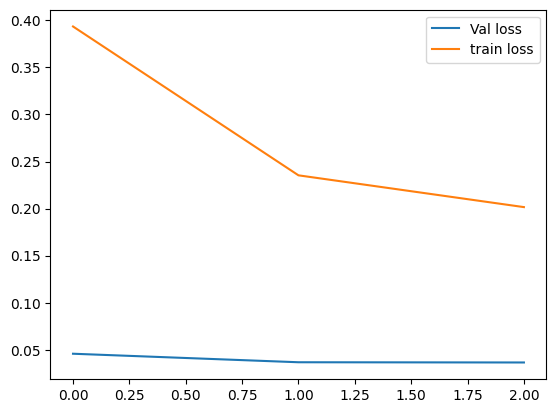

In [10]:
val_loss_ = [history[x]['val_loss'] for x in range(total_epochs)]
train_loss_ = [history[x]['loss'] for x in range(total_epochs)]

plt.figure()
plt.plot(val_loss_, label='Val loss')
plt.plot(train_loss_, label='train loss')
plt.legend()

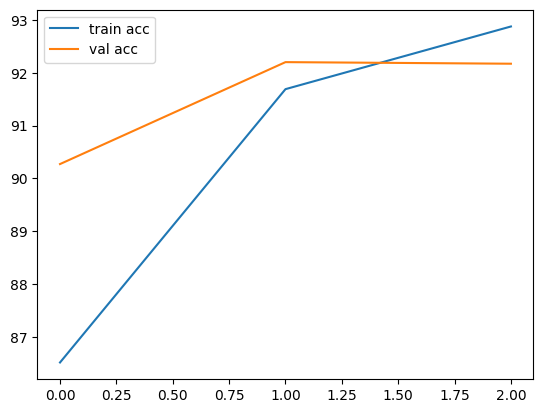

In [11]:
train_acc_ = [history[x]['train_acc'] for x in range(total_epochs)]
val_acc_ = [history[x]['val_acc'] for x in range(total_epochs)]

plt.figure()
plt.plot(train_acc_, label='train acc')
plt.plot(val_acc_, label='val acc')
plt.legend()

In [17]:
test_iter = iter(test_loader)

In [18]:
img, label = next(test_iter)
img, label = img.to(device), label.to(device)

result, _, _ = model(img)

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 7.77 GiB of which 282.50 MiB is free. Including non-PyTorch memory, this process has 7.22 GiB memory in use. Of the allocated memory 6.83 GiB is allocated by PyTorch, and 219.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
_, predicted = torch.max(result.data, 1)
print(predicted)

AttributeError: 'list' object has no attribute 'data'

In [ ]:
def show_images_with_labels_predicted(images, labels, result):
    fig = plt.figure(figsize=(18, 6))
    _, predicted = torch.max(result.data, 1)
    for idx in range(5):
        print(images[idx].shape)
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx][0].squeeze(), cmap='gray')
        ax.set_title(f"T: {class_names[labels[idx].item()]}, P: {class_names[predicted[idx].item()]}")
    plt.show()

In [ ]:
show_images_with_labels_predicted(img.to('cpu'), label.to('cpu'), result.to('cpu'))